In [1]:
import numpy as np, matplotlib.pyplot as plt, pandas as pd, scipy.optimize
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import pacf, pacf_yw

In [2]:
data = pd.read_csv('global.csv')
berlin = data[data['City'] == 'Berlin']
berlin = berlin[berlin['dt'] > '1799-12-01']
# berlin.iloc[1]['dt'] > '1743-12-02'

## Berlin

In [3]:
berlin.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
25174,1800-01-01,-2.289,2.237,Berlin,Germany,52.24N,13.14E
25175,1800-02-01,-2.704,5.605,Berlin,Germany,52.24N,13.14E
25176,1800-03-01,-1.532,5.009,Berlin,Germany,52.24N,13.14E
25177,1800-04-01,13.804,2.169,Berlin,Germany,52.24N,13.14E
25178,1800-05-01,16.429,1.437,Berlin,Germany,52.24N,13.14E


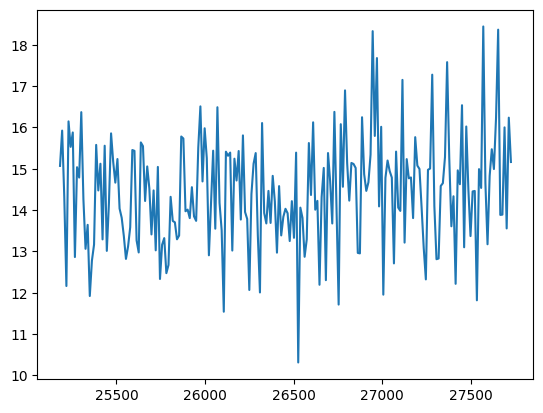

In [4]:
average = berlin['AverageTemperature']
plt.plot(average[8::12])

## Nowy York

In [5]:
df = pd.read_csv('nyc_temperature.csv')

In [6]:
df.head()

,date,tmax,tmin,tavg,departure,HDD,CDD,precipitation,new_snow,snow_depth
0,1/1/19,60,40,50.0,13.9,15,0,0.08,0,0
1,2/1/19,41,35,38.0,2.1,27,0,0,0,0
2,3/1/19,45,39,42.0,6.3,23,0,T,0,0
3,4/1/19,47,37,42.0,6.5,23,0,0,0,0
4,5/1/19,47,42,44.5,9.1,20,0,0.45,0,0


In [7]:
temp = df['tavg']
temphigh = df['tmax']
templow = df['tmin']

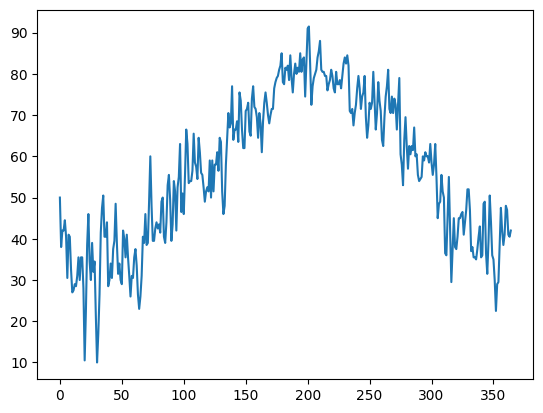

In [8]:
plt.plot(temp)
# plt.plot(temphigh, color = 'red', ls = ":")
# plt.plot(templow, ls = ":")

In [9]:
def sampleACVF(X, h):
    n = len(X)
    x_mean = np.mean(X)
    return 1/n*sum((X[i]-x_mean)*(X[i+abs(h)]-x_mean) for i in range(1,n-abs(h)))
def sampleACF(X, h):
    return sampleACVF(X, h)/sampleACVF(X, 0)

In [10]:
hs = np.arange(-50,50)
raw_acf = [sampleACF(temp,h) for h in hs]

Text(0.5, 1.0, 'ACF dla surowych danych')

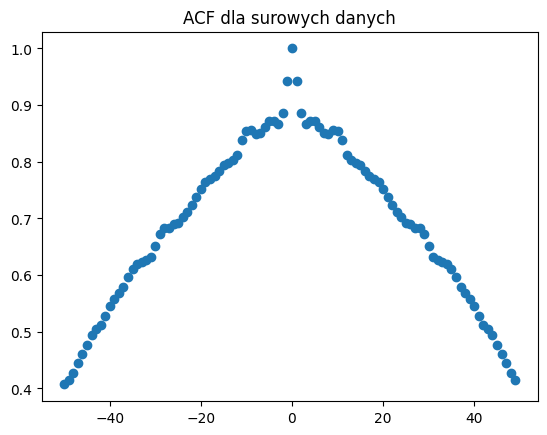

In [11]:
plt.scatter(np.arange(-50,50), raw_acf)
plt.title('ACF dla surowych danych')

In [12]:
def fit_sin(tt, yy):
    tt = np.array(tt)
    yy = np.array(yy)
    ff = np.fft.fftfreq(len(tt), (tt[1]-tt[0]))   # assume uniform spacing
    Fyy = abs(np.fft.fft(yy))
    guess_freq = abs(ff[np.argmax(Fyy[1:])+1])   # excluding the zero frequency "peak", which is related to offset
    guess_amp = np.std(yy) * 2.**0.5
    guess_offset = np.mean(yy)
    guess = np.array([guess_amp, 2.*np.pi*guess_freq, 0., guess_offset])

    def sinfunc(t, A, w, p, c):  return A * np.sin(w*t + p) + c
    popt, pcov = scipy.optimize.curve_fit(sinfunc, tt, yy, p0=guess)
    A, w, p, c = popt
    f = w/(2.*np.pi)
    fitfunc = lambda t: A * np.sin(w*t + p) + c
    return {"amp": A, "omega": w, "phase": p, "offset": c, "freq": f, "period": 1./f, "fitfunc": fitfunc, "maxcov": np.max(pcov), "rawres": (guess,popt,pcov)}

In [13]:
t1 = np.arange(0, 365)
fit1 = fit_sin(t1, temp) 

In [14]:
1/fit1['freq']

353.1511093637461

In [15]:
A, omega, phase, offset = fit1['amp'], fit1['omega'], fit1['phase'], fit1['offset']

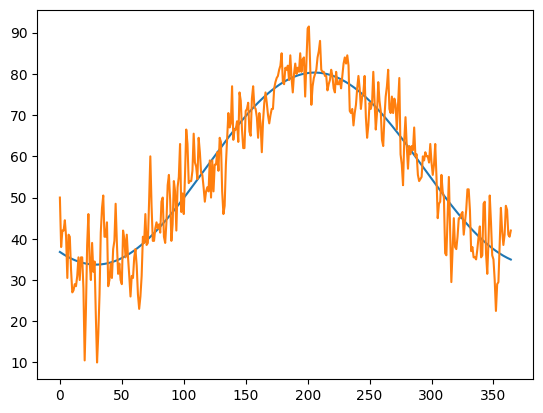

In [16]:
def s(t, A, w, p, c ):
  return A*np.sin(w*t +p) + c
plt.plot(t1, s(t1, A, omega, phase, offset))
plt.plot(t1, temp)

In [17]:
temp_= temp - s(t1, A, omega, phase, offset)

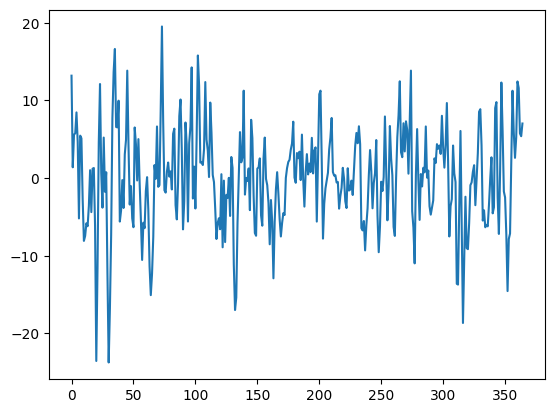

In [18]:
plt.plot(temp_)

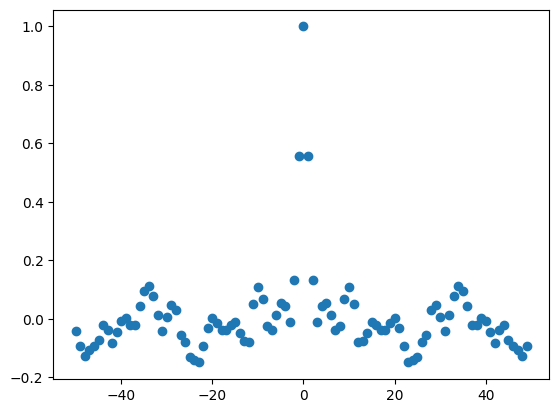

In [19]:
acf2 = [sampleACF(temp_, h) for h in hs]
plt.scatter(hs, acf2)

## Aleksandria (ten gigantyczny zbiór danych)

In [20]:
data['City'].unique()

array(['Abidjan', 'Addis Abeba', 'Ahmadabad', 'Aleppo', 'Alexandria',
       'Ankara', 'Baghdad', 'Bangalore', 'Bangkok', 'Belo Horizonte',
       'Berlin', 'Bogotá', 'Bombay', 'Brasília', 'Cairo', 'Calcutta',
       'Cali', 'Cape Town', 'Casablanca', 'Changchun', 'Chengdu',
       'Chicago', 'Chongqing', 'Dakar', 'Dalian', 'Dar Es Salaam',
       'Delhi', 'Dhaka', 'Durban', 'Faisalabad', 'Fortaleza', 'Gizeh',
       'Guangzhou', 'Harare', 'Harbin', 'Ho Chi Minh City', 'Hyderabad',
       'Ibadan', 'Istanbul', 'Izmir', 'Jaipur', 'Jakarta', 'Jiddah',
       'Jinan', 'Kabul', 'Kano', 'Kanpur', 'Karachi', 'Kiev', 'Kinshasa',
       'Lagos', 'Lahore', 'Lakhnau', 'Lima', 'London', 'Los Angeles',
       'Luanda', 'Madras', 'Madrid', 'Manila', 'Mashhad', 'Melbourne',
       'Mexico', 'Mogadishu', 'Montreal', 'Moscow', 'Nagoya', 'Nagpur',
       'Nairobi', 'Nanjing', 'New Delhi', 'New York', 'Paris', 'Peking',
       'Pune', 'Rangoon', 'Rio De Janeiro', 'Riyadh', 'Rome', 'São Paulo',
       'S

In [71]:
alexandria = data[data['City'] == 'Alexandria']
al = alexandria['AverageTemperature'][-481:-1]
t = np.linspace(1973, 2013, 480)

Text(0.5, 1.0, 'Surowe dane, Aleksandria 1973-2013')

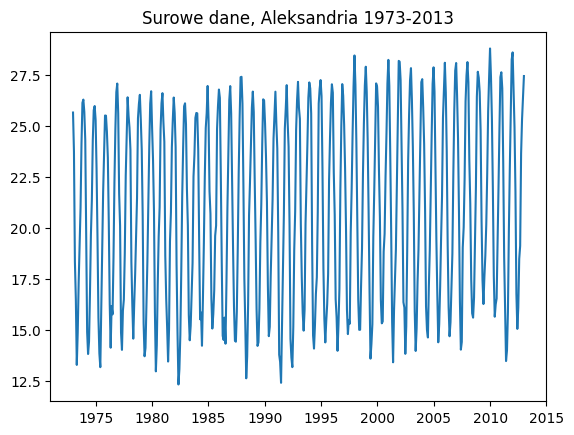

In [72]:
plt.plot(t, al)
plt.title('Surowe dane, Aleksandria 1973-2013')

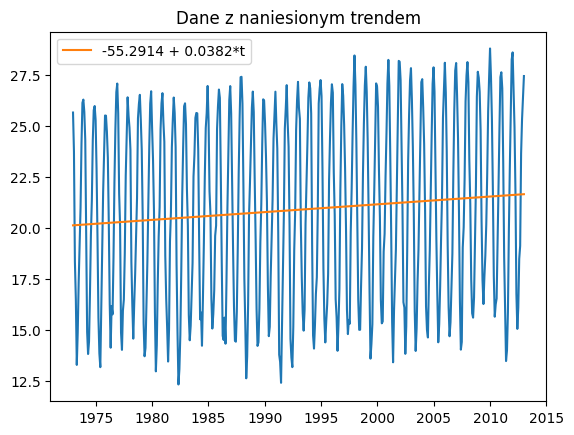

In [23]:
def oblicz_regresje(x, y):
    b1 = np.sum((x - np.mean(x)) * (y - np.mean(y))) / np.sum((x - np.mean(x))**2)
    b0 = np.mean(y) - b1 * np.mean(x)
    return b0, b1

b0, b1 = oblicz_regresje(t, al)
mt_hat = b1*t + b0
plt.plot(t, al)
plt.plot(t, mt_hat, label = f'{b0:.4f} + {b1:.4f}*t')
plt.title('Dane z naniesionym trendem'); plt.legend()

Text(0.5, 1.0, 'dane bez trendu')

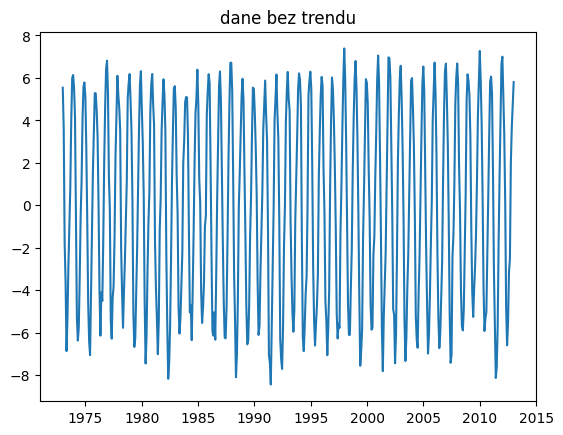

In [24]:
X_star = al - mt_hat
plt.plot(t, X_star); plt.title('dane bez trendu')

Text(0.5, 1.0, 'Dane bez trendu z naniesioną sezonowością')

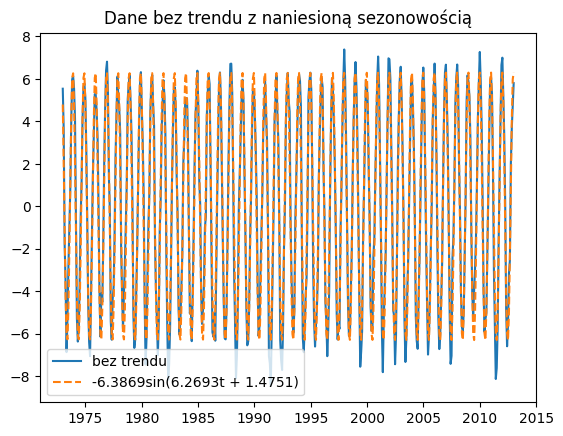

In [67]:
fit = fit_sin(t, X_star) 
A, omega, phase, offset = fit['amp'], fit['omega'], fit['phase'], fit['offset']
X2 = X_star - s(t, A, omega, phase, offset)
plt.plot(t, X_star, label = 'bez trendu')
plt.plot(t, s(t, A, omega, phase, offset), label = f'{A:.4f}sin({omega:.4f}t + {phase:.4f})', ls = '--'); plt.legend()
plt.title('Dane bez trendu z naniesioną sezonowością')

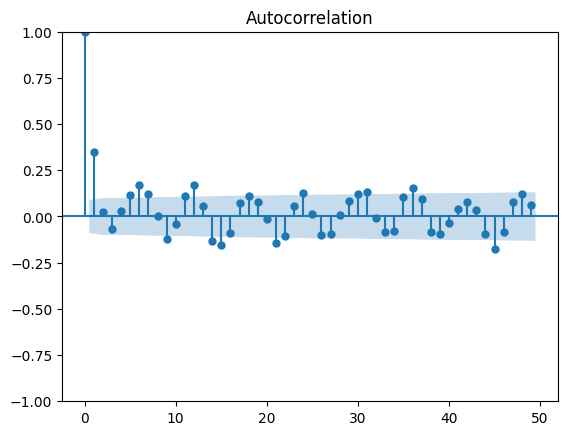

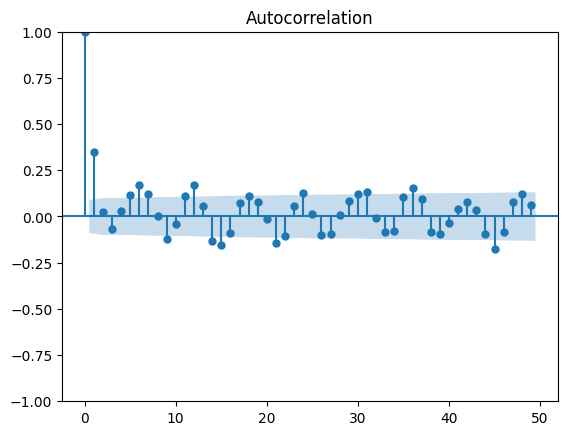

In [26]:
plot_acf(X2, lags = np.arange(50))

In [27]:
1/fit['freq']

1.0022197491021103

In [59]:
first_ten = X_star[:120]
last_ten = X_star[-120:]

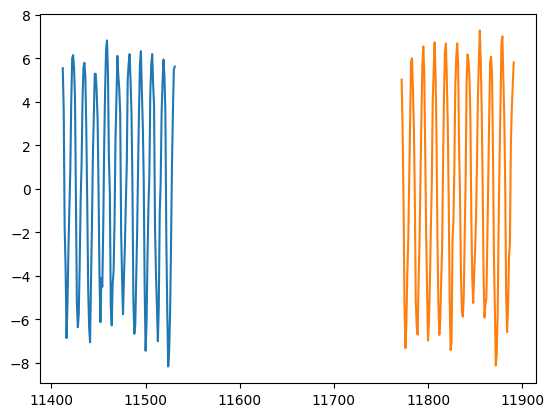

In [60]:
plt.plot(first_ten)
plt.plot(last_ten)
plt.show()

In [61]:
f_coeff = fit_sin(np.arange(120), first_ten)
l_coeff = fit_sin(np.arange(120), last_ten)

In [70]:
# liczymy okres w miesiącach
1/f_coeff['freq'], 1/l_coeff['freq']

(12.009069931244367, 12.000278087285968)

In [63]:
f_coeff['period'],l_coeff['period'], fit['period'], fit1['period']

(12.009069931244367, 12.000278087285968, 1.0022197491021103, 353.1511093637461)

In [52]:
alexandria[-478:-477]

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
11415,1973-12-01,16.503,0.319,Alexandria,Egypt,31.35N,30.16E


In [51]:
alexandria[-9:-8]

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
11884,2013-01-01,15.039,0.334,Alexandria,Egypt,31.35N,30.16E


In [74]:
fit_sin(np.arange(480), X_star)['period'], fit_sin(t, X_star)['period'], 

(12.001580899215833, 1.0022197491021103)